In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
class PrintEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, N):
        super(PrintEveryNEpochs, self).__init__()
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

In [3]:
import os
os.chdir(r'd:\reconstrucao_estatistica_pesqueira\reconstrucao_estatistica_brasileira\RE\Reconstru--o')
print(os.getcwd())

d:\reconstrucao_estatistica_pesqueira\reconstrucao_estatistica_brasileira\RE\Reconstru--o


In [4]:
df = pd.read_excel('RJ_Reconstrucao_Lutjanidae_2024_08_07.xlsx')

In [5]:
df = df.drop(columns=['TOTAL_FISHES_M', 'TOTAL_FISHES_F&M', 'TOTAL_GROUPS_F&M'])


df_Lutjanidae = df.set_index('Ano')
df_Lutjanidae['Total'] = df_Lutjanidae.sum(axis=1).dropna()



for coluna in df_Lutjanidae.columns[:-1]:  
    df_Lutjanidae[coluna + '_proporcao'] = df_Lutjanidae[coluna] / df_Lutjanidae['Total']
    


df_Lutjanidae.reset_index(inplace=True)
print(df_Lutjanidae)


     Ano  Vermelho_art  Vermelho_ind  Ver_henrique_art  Ver_henrique_ind  \
0   1950           NaN           NaN               NaN               NaN   
1   1951           NaN           NaN               NaN               NaN   
2   1952           NaN           NaN               NaN               NaN   
3   1953           NaN           NaN               NaN               NaN   
4   1954           NaN           NaN               NaN               NaN   
..   ...           ...           ...               ...               ...   
68  2018    12817.0000        0.0576            0.0063               NaN   
69  2019        0.5147        0.0376            0.1990           0.00800   
70  2020        0.1491           NaN            0.3236           0.04715   
71  2021        0.0471        0.0378            0.6080           0.04250   
72  2022        0.0770           NaN            0.5802           0.06700   

      Cioba_art  Cioba_ind  Olho_vidro_art  Guaiuba_art  Guaiuba_ind  ...  \
0         

# Vermelho artesanal MLP

In [6]:
x0 = df_Lutjanidae[['Ano', 'Vermelho_art_proporcao']].dropna().values


df_x0= pd.DataFrame(x0, columns= ['Ano', 'Vermelho_art_proporcao'])


x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Vermelho_art_proporcao'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.6184002757072449
Epoch 200: loss = 0.2823970913887024
Epoch 300: loss = 0.25229546427726746
Epoch 400: loss = 0.24273423850536346
Epoch 500: loss = 0.22866766154766083
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


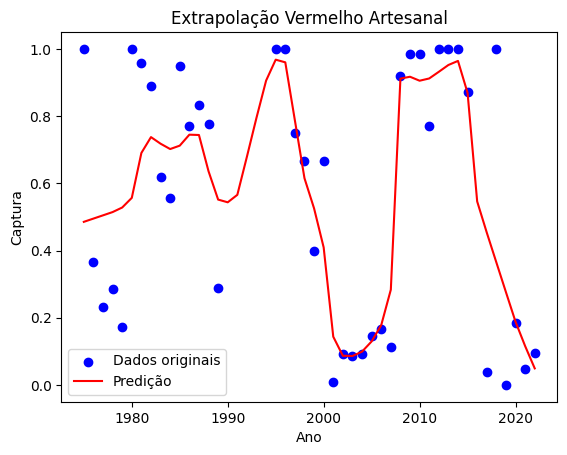

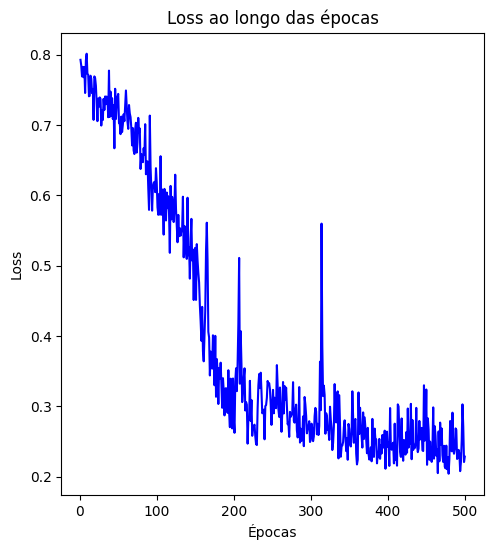

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=500, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)
model.save_weights('d:/reconstrucao_estatistica_pesqueira/reconstrucao_estatistica_brasileira/RE/Reconstru--o/PESOS/.weights.h5', overwrite=True)
x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Extrapolação Vermelho Artesanal')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predição para o ano 1950: 0.17643332481384277
Predição para o ano 1951: 0.18910661339759827
Predição para o ano 1952: 0.2017783522605896
Predição para o ano 1953: 0.21444082260131836
Predição para o ano 1954: 0.22710329294204712
Predição para o ano 1955: 0.23976582288742065
Predição para o ano 1956: 0.2524283528327942
Predição para o ano 1957: 0.26509079337120056
Predição para o ano 1958: 0.277770459651947
Predição para o ano 1959: 0.2904728949069977
Predição para o ano 1960: 0.30324602127075195
Predição para o ano 1961: 0.31614503264427185
Predição para o ano 1962: 0.3290441930294037
Predição para o ano 1963: 0.3419432044029236
Predição para o ano 1964: 0.3548422157764435
Predição para o ano 1965: 0.36774125695228577
Predição para o ano 1966: 0.3805578351020813
Predição para o ano 1967: 0.39306944608688354
Predição para o ano 1968: 0.40556856989860535
Predição para o ano 1969: 0.41749006509780884
Predição para o ano 1970: 0.4292479455471039
Prediç

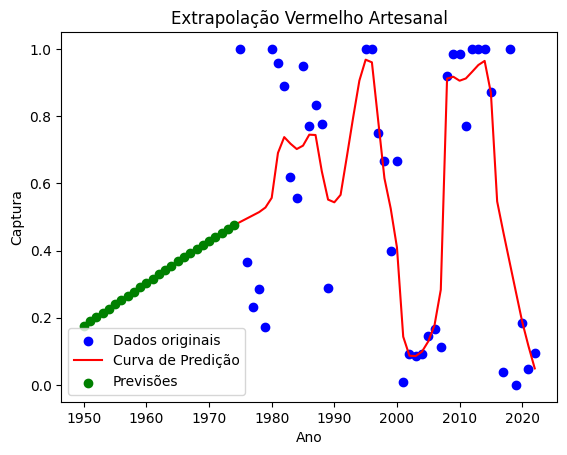

In [8]:
anos_para_prever = np.array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std
predicoes_normalizadas = model.predict(anos_para_prever_normalizados)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')
df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_combined = pd.concat([df_combined, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Extrapolação Vermelho Artesanal')
plt.legend()
plt.show()



# Vermelho artesanal CNN

In [20]:
x0 = df_Lutjanidae[['Ano', 'Vermelho_art_proporcao']].dropna().values


df_x0= pd.DataFrame(x0, columns= ['Ano', 'Vermelho_art_proporcao'])


x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Vermelho_art_proporcao'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

x_cnn = np.expand_dims(x_normalized, axis=2)

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.31314945220947266
Epoch 200: loss = 0.2610904574394226
Epoch 300: loss = 0.21734130382537842
Epoch 400: loss = 0.21586580574512482
Epoch 500: loss = 0.21716377139091492
Epoch 600: loss = 0.1755414605140686
Epoch 700: loss = 0.171321302652359
Epoch 800: loss = 0.18490232527256012
Epoch 900: loss = 0.1241397112607956
Epoch 1000: loss = 0.21606168150901794
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026FA273D120> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to ht

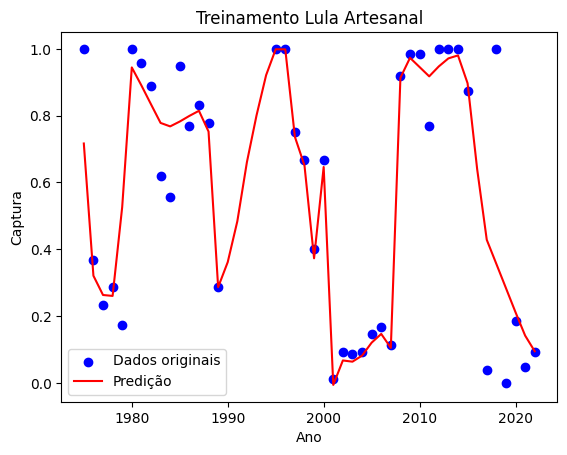

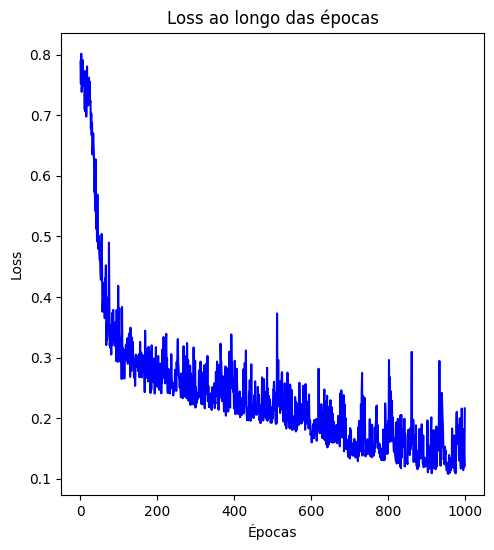

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=1, activation='relu', input_shape=(x_cnn.shape[1], 1)),
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100)

history = model.fit(
    x_cnn, y_normalized, 
    epochs=1000, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)

x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
x_all_cnn = np.expand_dims(x_all_normalized, axis=2)

y_all_predicted_normalized = model.predict(x_all_cnn)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Treinamento Lula Artesanal')
plt.legend()
plt.show()

loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predição para o ano 1950: 1.6374435424804688
Predição para o ano 1951: 1.6135011911392212
Predição para o ano 1952: 1.5892341136932373
Predição para o ano 1953: 1.5647015571594238
Predição para o ano 1954: 1.540175199508667
Predição para o ano 1955: 1.515408992767334
Predição para o ano 1956: 1.4901922941207886
Predição para o ano 1957: 1.4636211395263672
Predição para o ano 1958: 1.4370499849319458
Predição para o ano 1959: 1.4104790687561035
Predição para o ano 1960: 1.3837335109710693
Predição para o ano 1961: 1.3566858768463135
Predição para o ano 1962: 1.3296383619308472
Predição para o ano 1963: 1.3025907278060913
Predição para o ano 1964: 1.2755436897277832
Predição para o ano 1965: 1.2484078407287598
Predição para o ano 1966: 1.2212064266204834
Predição para o ano 1967: 1.1941947937011719
Predição para o ano 1968: 1.1674726009368896
Predição para o ano 1969: 1.1416096687316895
Predição para o ano 1970: 1.1157817840576172
Predição para o ano

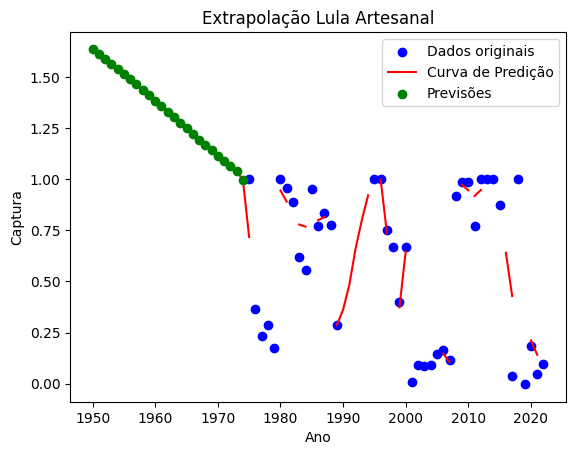

In [24]:

anos_para_prever = np.array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974]).reshape(-1, 1)
anos_para_prever_normalizados = (anos_para_prever - x_mean) / x_std


anos_para_prever_cnn = np.expand_dims(anos_para_prever_normalizados, axis=2)


predicoes_normalizadas = model.predict(anos_para_prever_cnn)
predicoes = predicoes_normalizadas * y_std + y_mean


for ano, predicao in zip(anos_para_prever.flatten(), predicoes.flatten()):
    print(f"Predição para o ano {ano}: {predicao}")


df_anos_para_prever = pd.DataFrame({'Ano': anos_para_prever.flatten(), 'Captura Preditos': predicoes.flatten()})
df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.concat([df_predicted, df_all_predicted, df_anos_para_prever]).drop_duplicates().sort_values(by='Ano')

# Plotar os resultados
plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Curva de Predição')
plt.scatter(df_anos_para_prever['Ano'], df_anos_para_prever['Captura Preditos'], color='green', label='Previsões', zorder=5)
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Extrapolação Lula Artesanal')
plt.legend()
plt.show()